# (Part 2) Figure 4: Water column presence and depths

Use [monte_carlo.yaml](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/envs/monte_carlo.yaml) to create an environment for this notebook:
```
 conda env create -f monte_carlo.yaml
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```


**Useful information**: 
- this code was developed with `Python 3.6`
- aggregation files were created with [incremental_sums.py](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/blob/main/aggregation_scripts/Incremental_Sums.py).
- the output from `Incremental_Sums.py` was saved to (and loaded from) `../../analysis_files/aggregated_spills_output/`
- a graphics style template in [../style_templates](https://github.com/MIDOSS/MuellerEtAl_MIDOSS_paper/tree/main/style_templates) was used.

In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import os
from copy import copy
import matplotlib.ticker as ticker
import matplotlib
import scipy.stats as st
import matplotlib.ticker as ticker
import cmocean.cm as cm

# Load aggregated results

In [2]:
# define directory paths
if os.sys.platform=="darwin": # For Shuga
    graphics_directory = Path(
         '/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/graphics'
    )
    # Aggregated files path
    agg_dir = Path('../../analysis_files/aggregated_spills_output/')
    # graphics style
    plt.style.use(r"../style_templates/MuellerEtAl_matplotlibrc.template")
else:
    # Aggregated files path
    agg_dir = Path('/data/sallen/MIDOSS/aggregated_spills_files/')
    # monte carlo spills file
    spill_dir = Path('/ocean/rmueller/MIDOSS/spill_files_091921/')
    # MEOPAR ASM graphics directory
    graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics')

# load aggregated results
oil = xr.open_dataset(agg_dir/f'fiftieth_55_oils.nc')

# Refine graphics

In [3]:
# Define SalishSeaCast grid spacing for plotting x-, y-axis distances
dx=440 # x-grid spacing in m
dy=500 # y-grid spacing in m

# set colormap so it's white (water) and papayawhip (land)
my_cmap = cm.algae #matplotlib.colormaps.get_cmap(cm.colors.Colormap('Greens'))# Python 3.7+
my_cmap.set_under('w')
my_cmap.set_over('papayawhip')

%matplotlib inline

# Graphic limits
imin = 0
jmin, jmax = 0, 398
imax = imin + (jmax - jmin)*2/500*440
imax = 898
aspect = 500/440

## Load SalishSeaCast grid 

In [4]:
mesh_mask = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
tmask = 1- mesh_mask.tmaskutil[0]
divarea = 1/(mesh_mask.e1t[0, 1:-1, 1:-1] * mesh_mask.e2t[0, 1:-1, 1:-1])
alength = 1/np.maximum(mesh_mask.e1t[0, 1:-1:, 1:-1], mesh_mask.e2t[0, 1:-1, 1:-1])
mesh_mask.close()

In [5]:
# # create an empty dictionary named "total" that has the same keys as "water"
# total = {**water}
# for key, value in water.items():
#     total[key] = [value , sfc[key], beach[key]]

## Estimate water column presence

In [6]:
ma_deep_pres = np.ma.masked_array(oil.deeppresence, oil.deeppresence == 0)

# Set bounds for calculation. Good if good to 5 m or 25% of depth
absol = 5
perol = 0.25

# noise
eps = 1e-7

# number of spills min_spillsed to be included in quantile calculation
min_spills = 4

ma_deep_location = np.ma.masked_array(oil.deep_location[0]/(oil.deeppresence + eps), 
                                      oil.deeppresence == 0)
print (oil.deep_location.shape)
location_25 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.25, axis=0)
location_median = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.5, axis=0)
location_75 = np.quantile(oil.deep_location/(oil.deeppresence + eps), 0.75, axis=0)

print (location_25.shape)

location = np.ma.masked_array(
    oil.deep_location[0]/(oil.deeppresence + eps), 
    mask = ((oil.deeppresence < min_spills) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location)))
)
# location = np.ma.masked_array(
#     location_median, 
#     mask = (oil.deeppresence < min_spills) | (
#     (location_75 - location_25 > absol) 
#     & (location_75 - location_25 > perol*ma_deep_location))) 

depth_range = np.ma.masked_array(
    location_75 - location_25, 
    mask = ((oil.deeppresence < min_spills) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location)) )
)

print (ma_deep_location.max())

(50, 896, 396)
(896, 396)
279.9262886394291


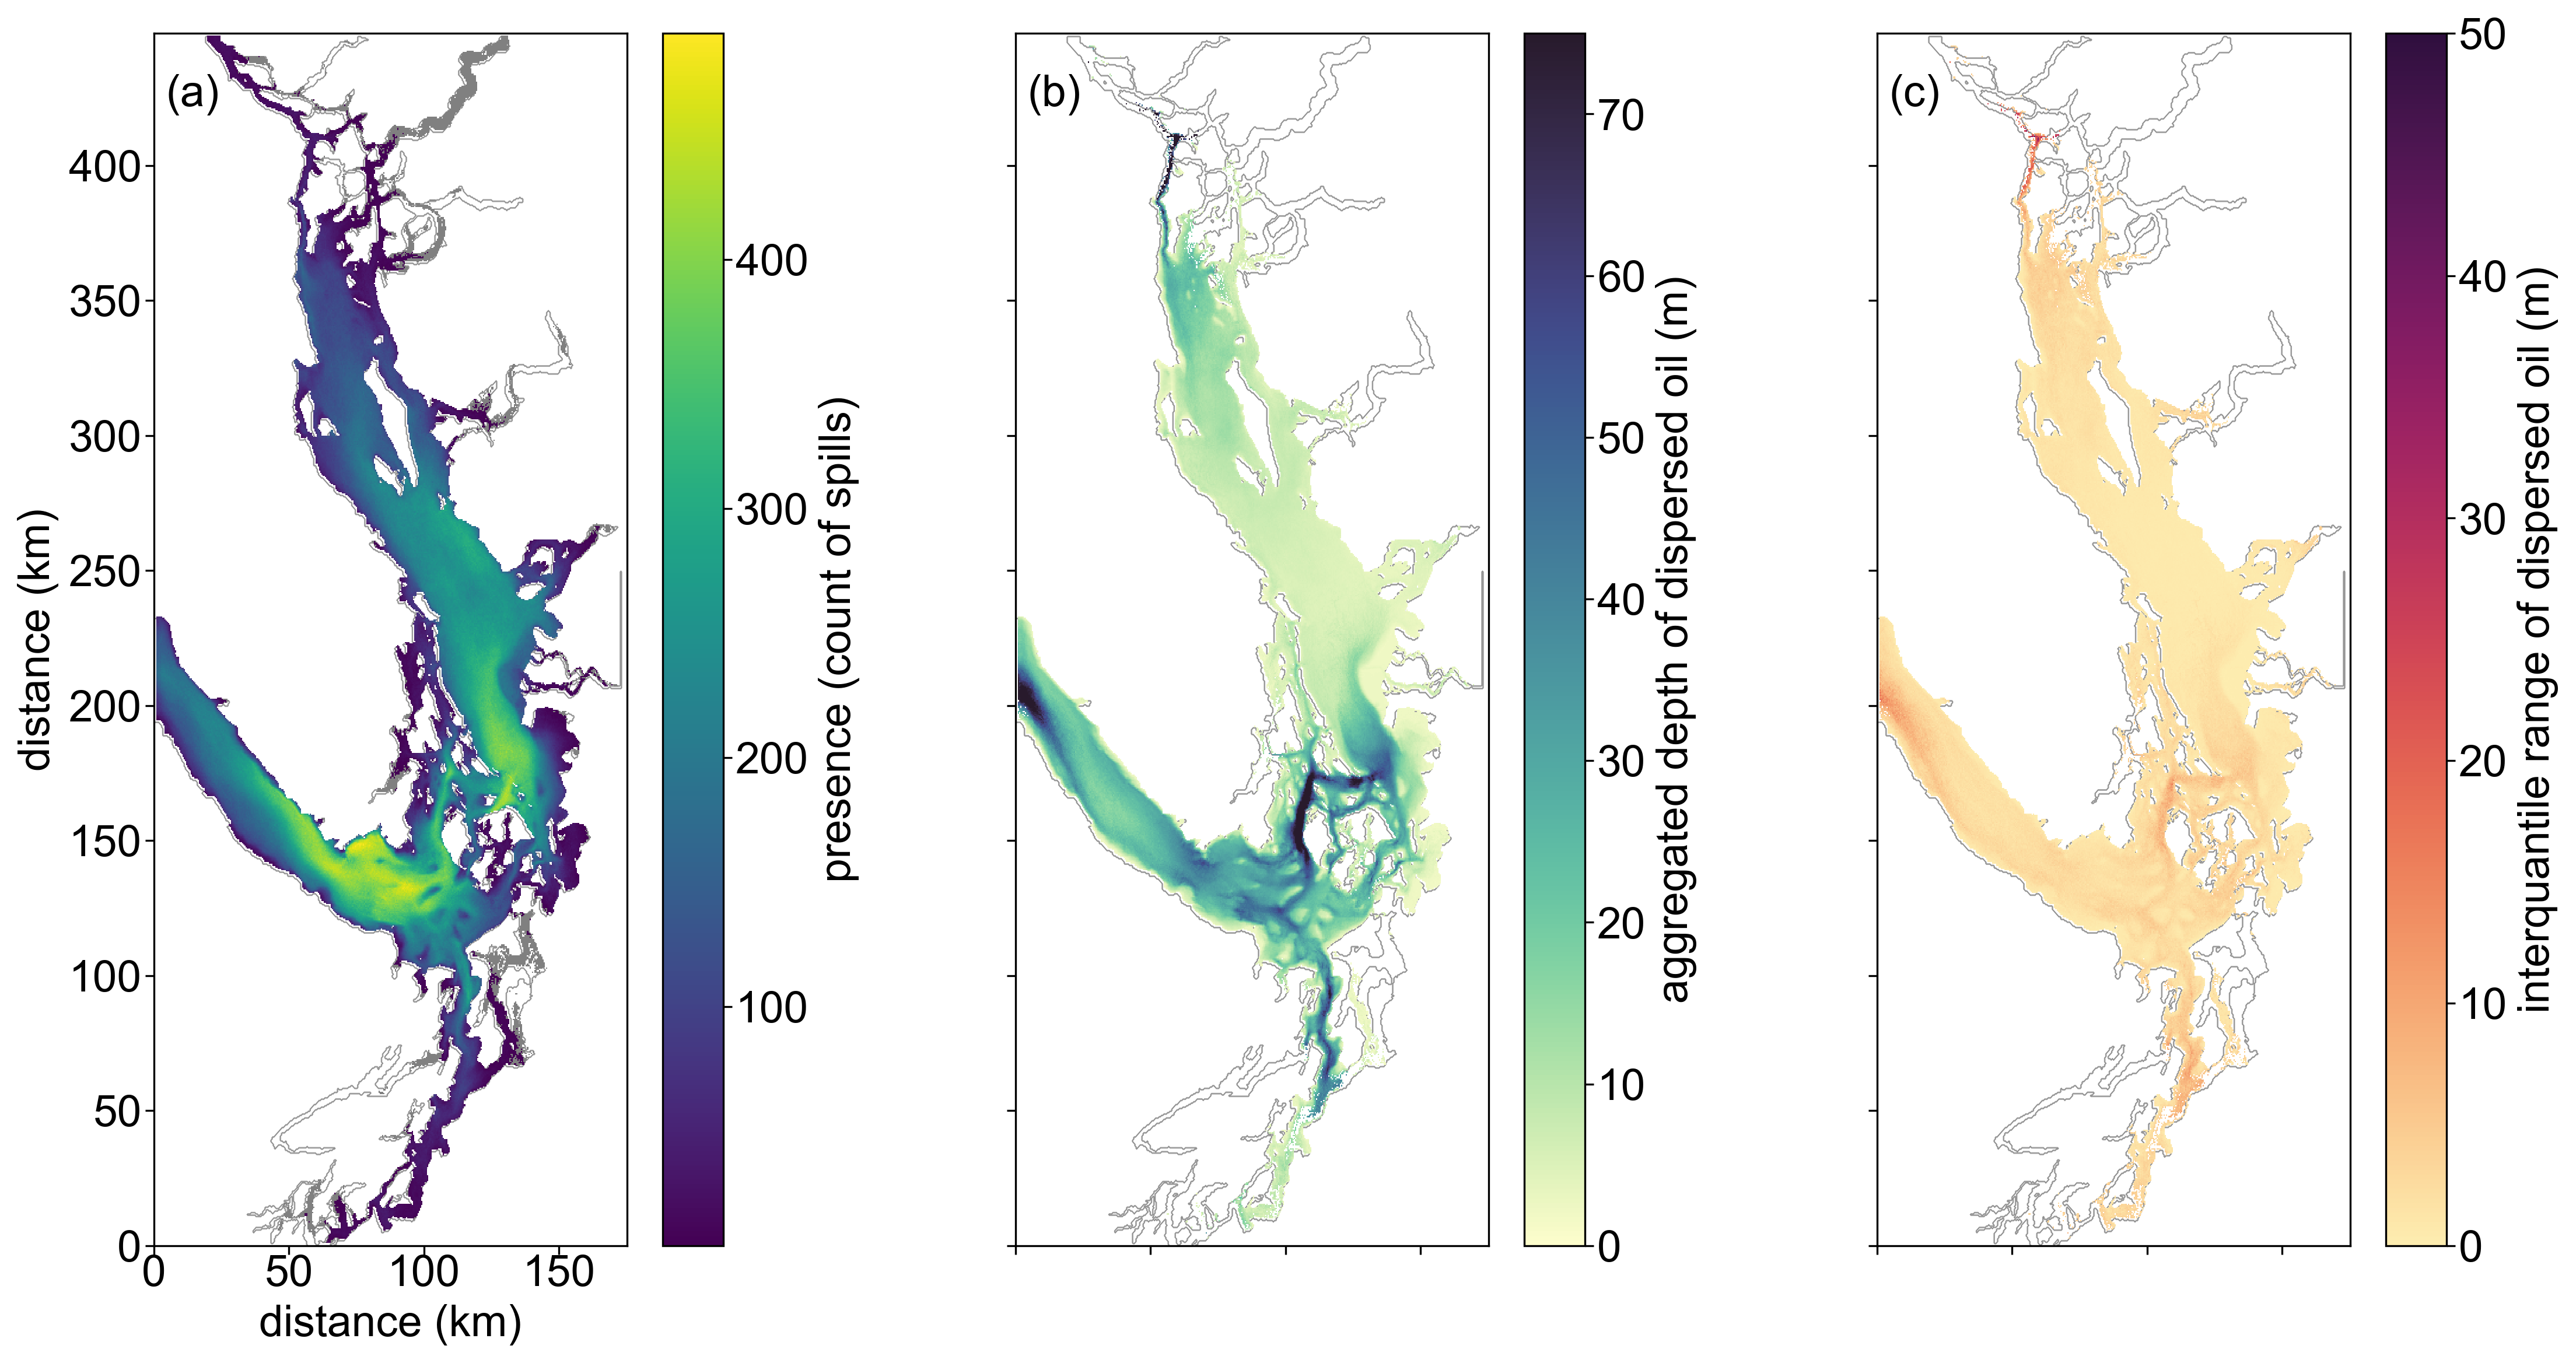

In [7]:
fig, axs = plt.subplots(
    1, 3, 
    figsize=(18, 9), 
    gridspec_kw={'hspace': 0.0}
)

vmin, vmax = 0.01, 50

subplot_labels=['(a)','(b)','(c)']
for idx,ax in enumerate(axs):
    ax.contour(tmask[1:, 1:], linewidths=.2, colors='grey', alpha=.5)
    ax.set_ylim(imin, imax)
    ax.set_xlim(jmin, jmax)
    ax.set_aspect(aspect)
    xticks = np.arange(0, 200, 50)/.44
    ax.set_xticks(xticks)
    ax.text(10,imax*0.94,subplot_labels[idx]) 
    if idx != 0:
        ax.set_xticklabels('')
        ax.set_yticklabels('')
    else:
        # convert axis labels to km
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: '{:g}'.format(dy*y/1000))
        )
        ax.xaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, _: '{:g}'.format(dx*x/1000))
        )
        ax.set_ylabel('distance (km)')
        ax.set_xlabel('distance (km)')
        
axs[0].set_ylabel('distance (km)')

# Number of spills present at depth (min = 4) 
cmap = copy(plt.get_cmap('viridis'))
cmap.set_under('grey')
C = axs[0].pcolormesh(
    np.arange(jmin+1, jmax), 
    np.arange(imin+1, imax), 
    ma_deep_pres, 
    zorder=2, vmin=min_spills, cmap=cmap
)
cb = fig.colorbar(C, ax=axs[0]);    
cb.set_label('presence (count of spills)')

filter_location = copy(location)
filter_location[ma_deep_pres < min_spills] = -1

# average depth of spills
cmap = copy(cm.deep)
cmap.set_under('w')
C = axs[1].pcolormesh(
    np.arange(jmin+1, jmax), 
    np.arange(imin+1, imax),
    filter_location,
    zorder=2, vmin=0, vmax=75, cmap=cmap
)
cb = fig.colorbar(C, ax=axs[1]);
cb.set_label('aggregated depth of dispersed oil (m)')


filter_del = copy(depth_range)
filter_del[ma_deep_pres < min_spills] = -1

cmap = copy(cm.matter)
cmap.set_under('w')
C = axs[2].pcolormesh(
    np.arange(jmin+1, jmax), 
    np.arange(imin+1, imax), 
    filter_del, 
    zorder=2, vmin=0, vmax=50, cmap=cmap,
)
cb = fig.colorbar(C, ax=axs[2]);
cb.set_label('interquantile range of dispersed oil (m)')
fig.savefig('Part2_Figure4_watercol_presence.png');

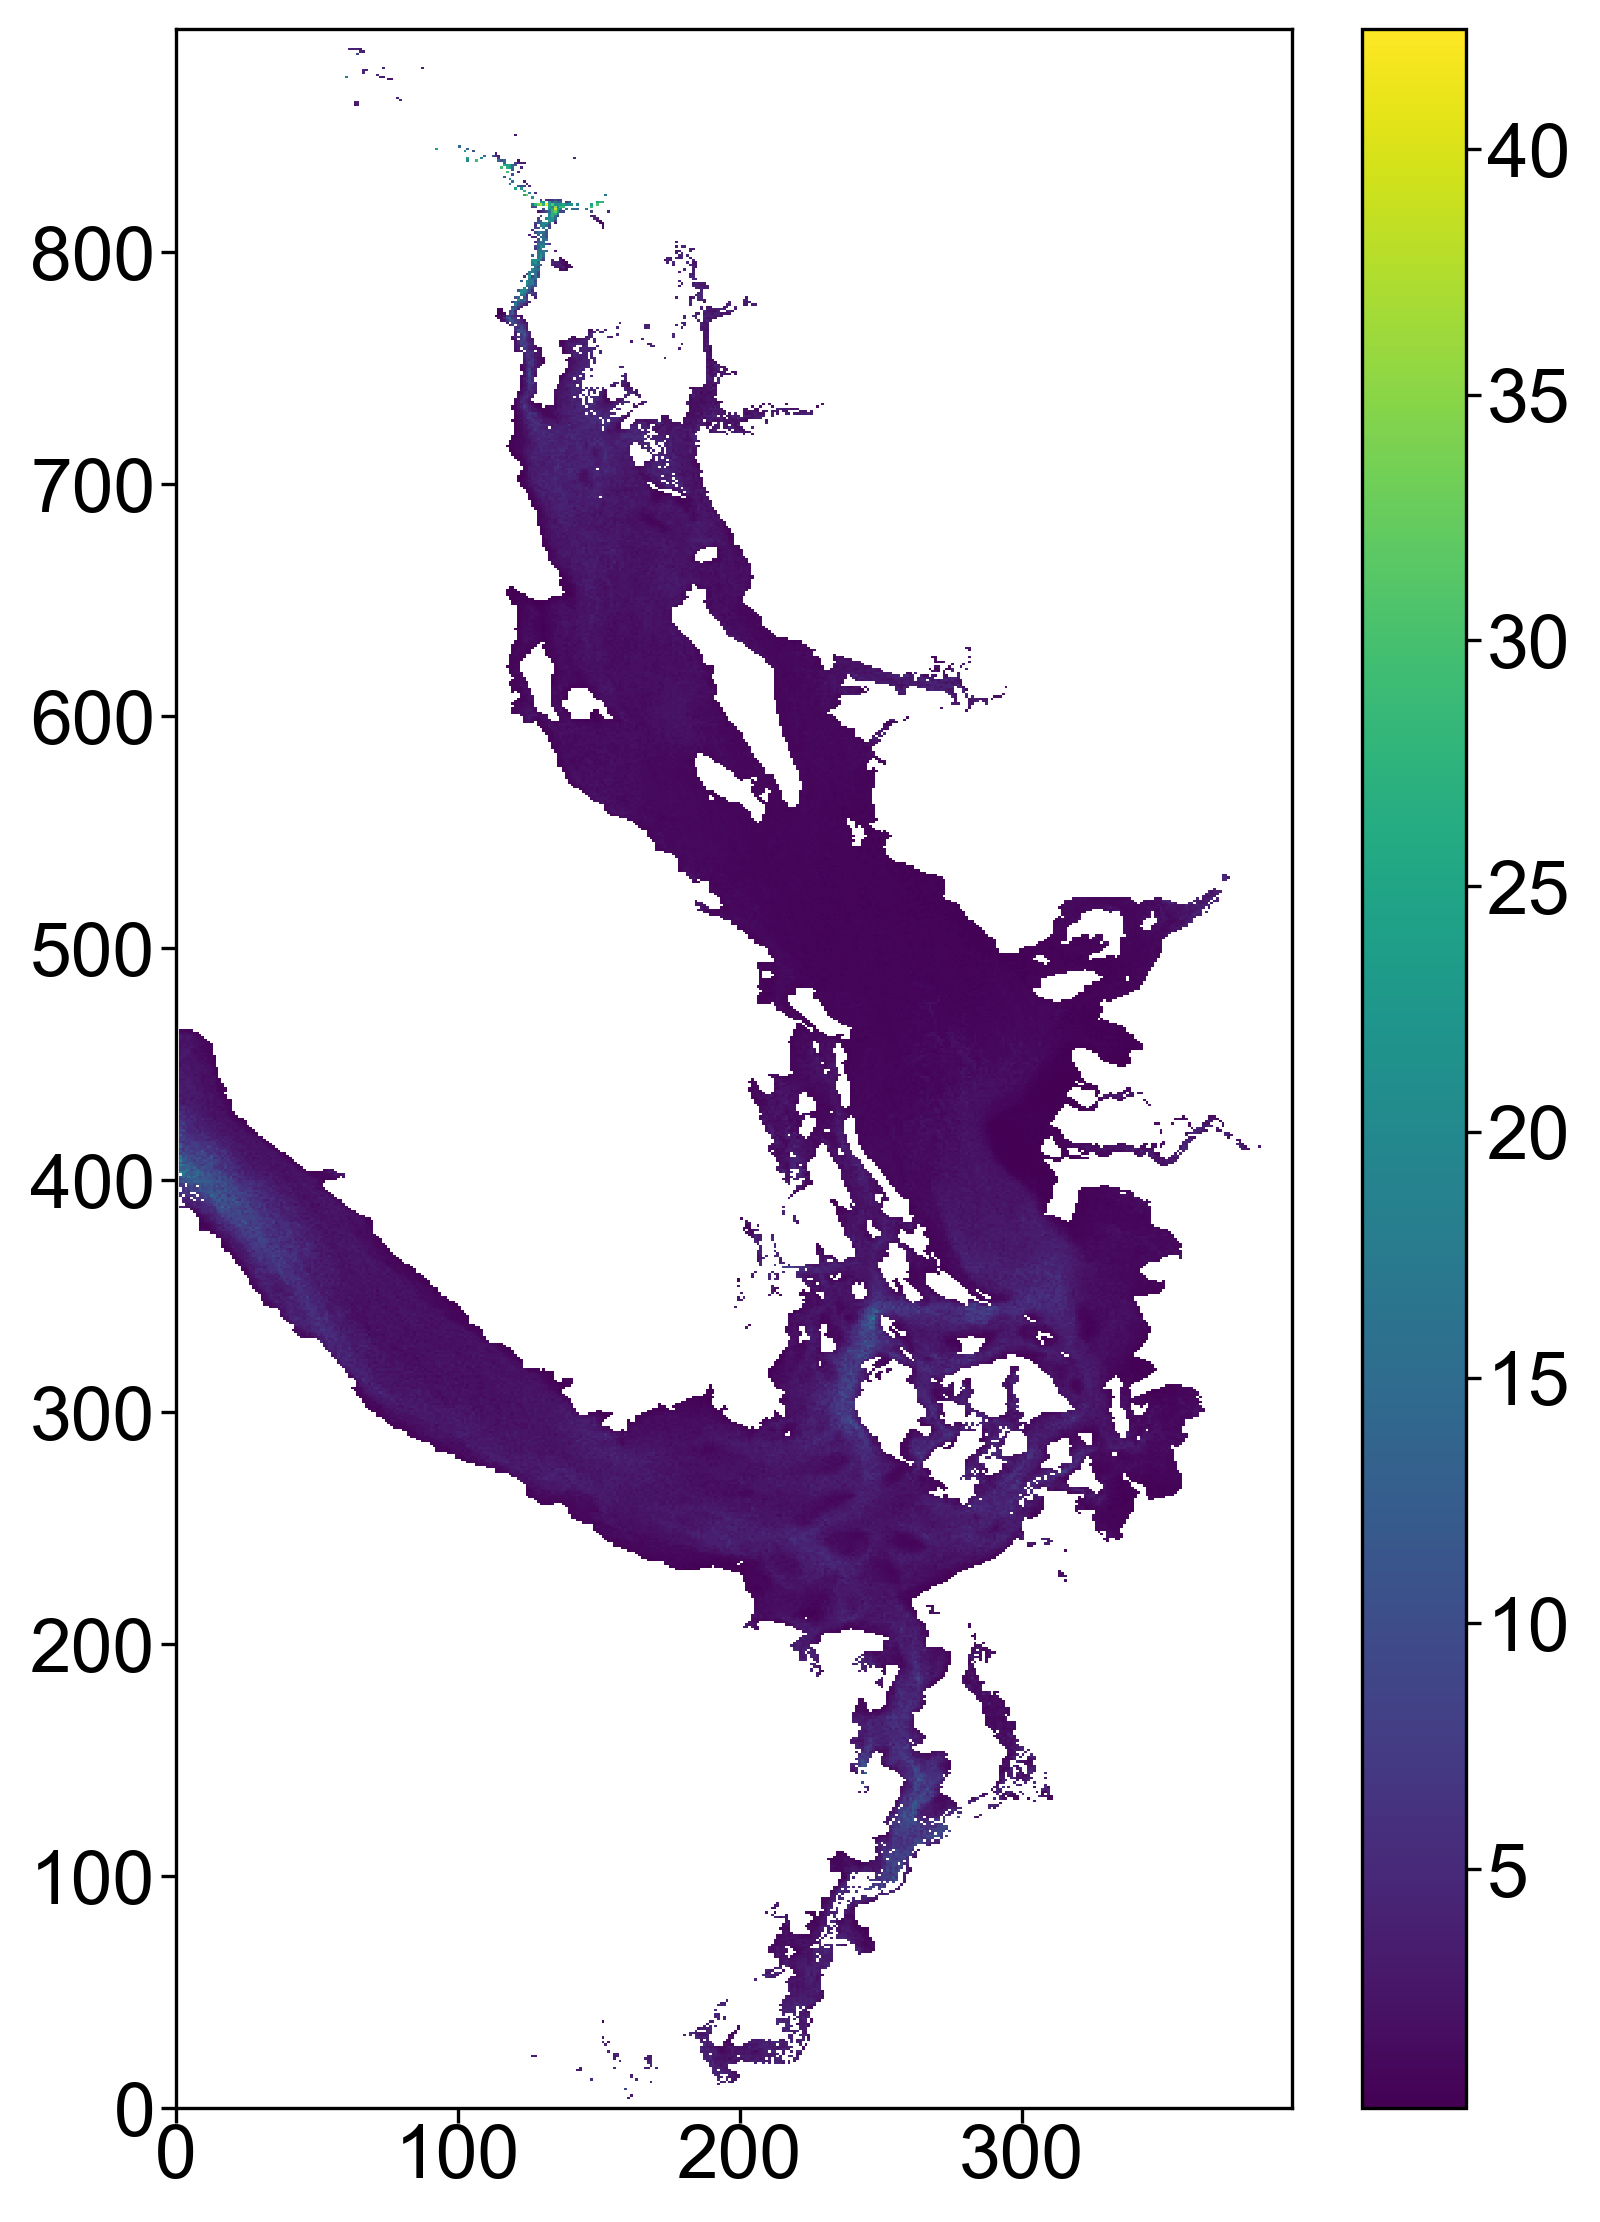

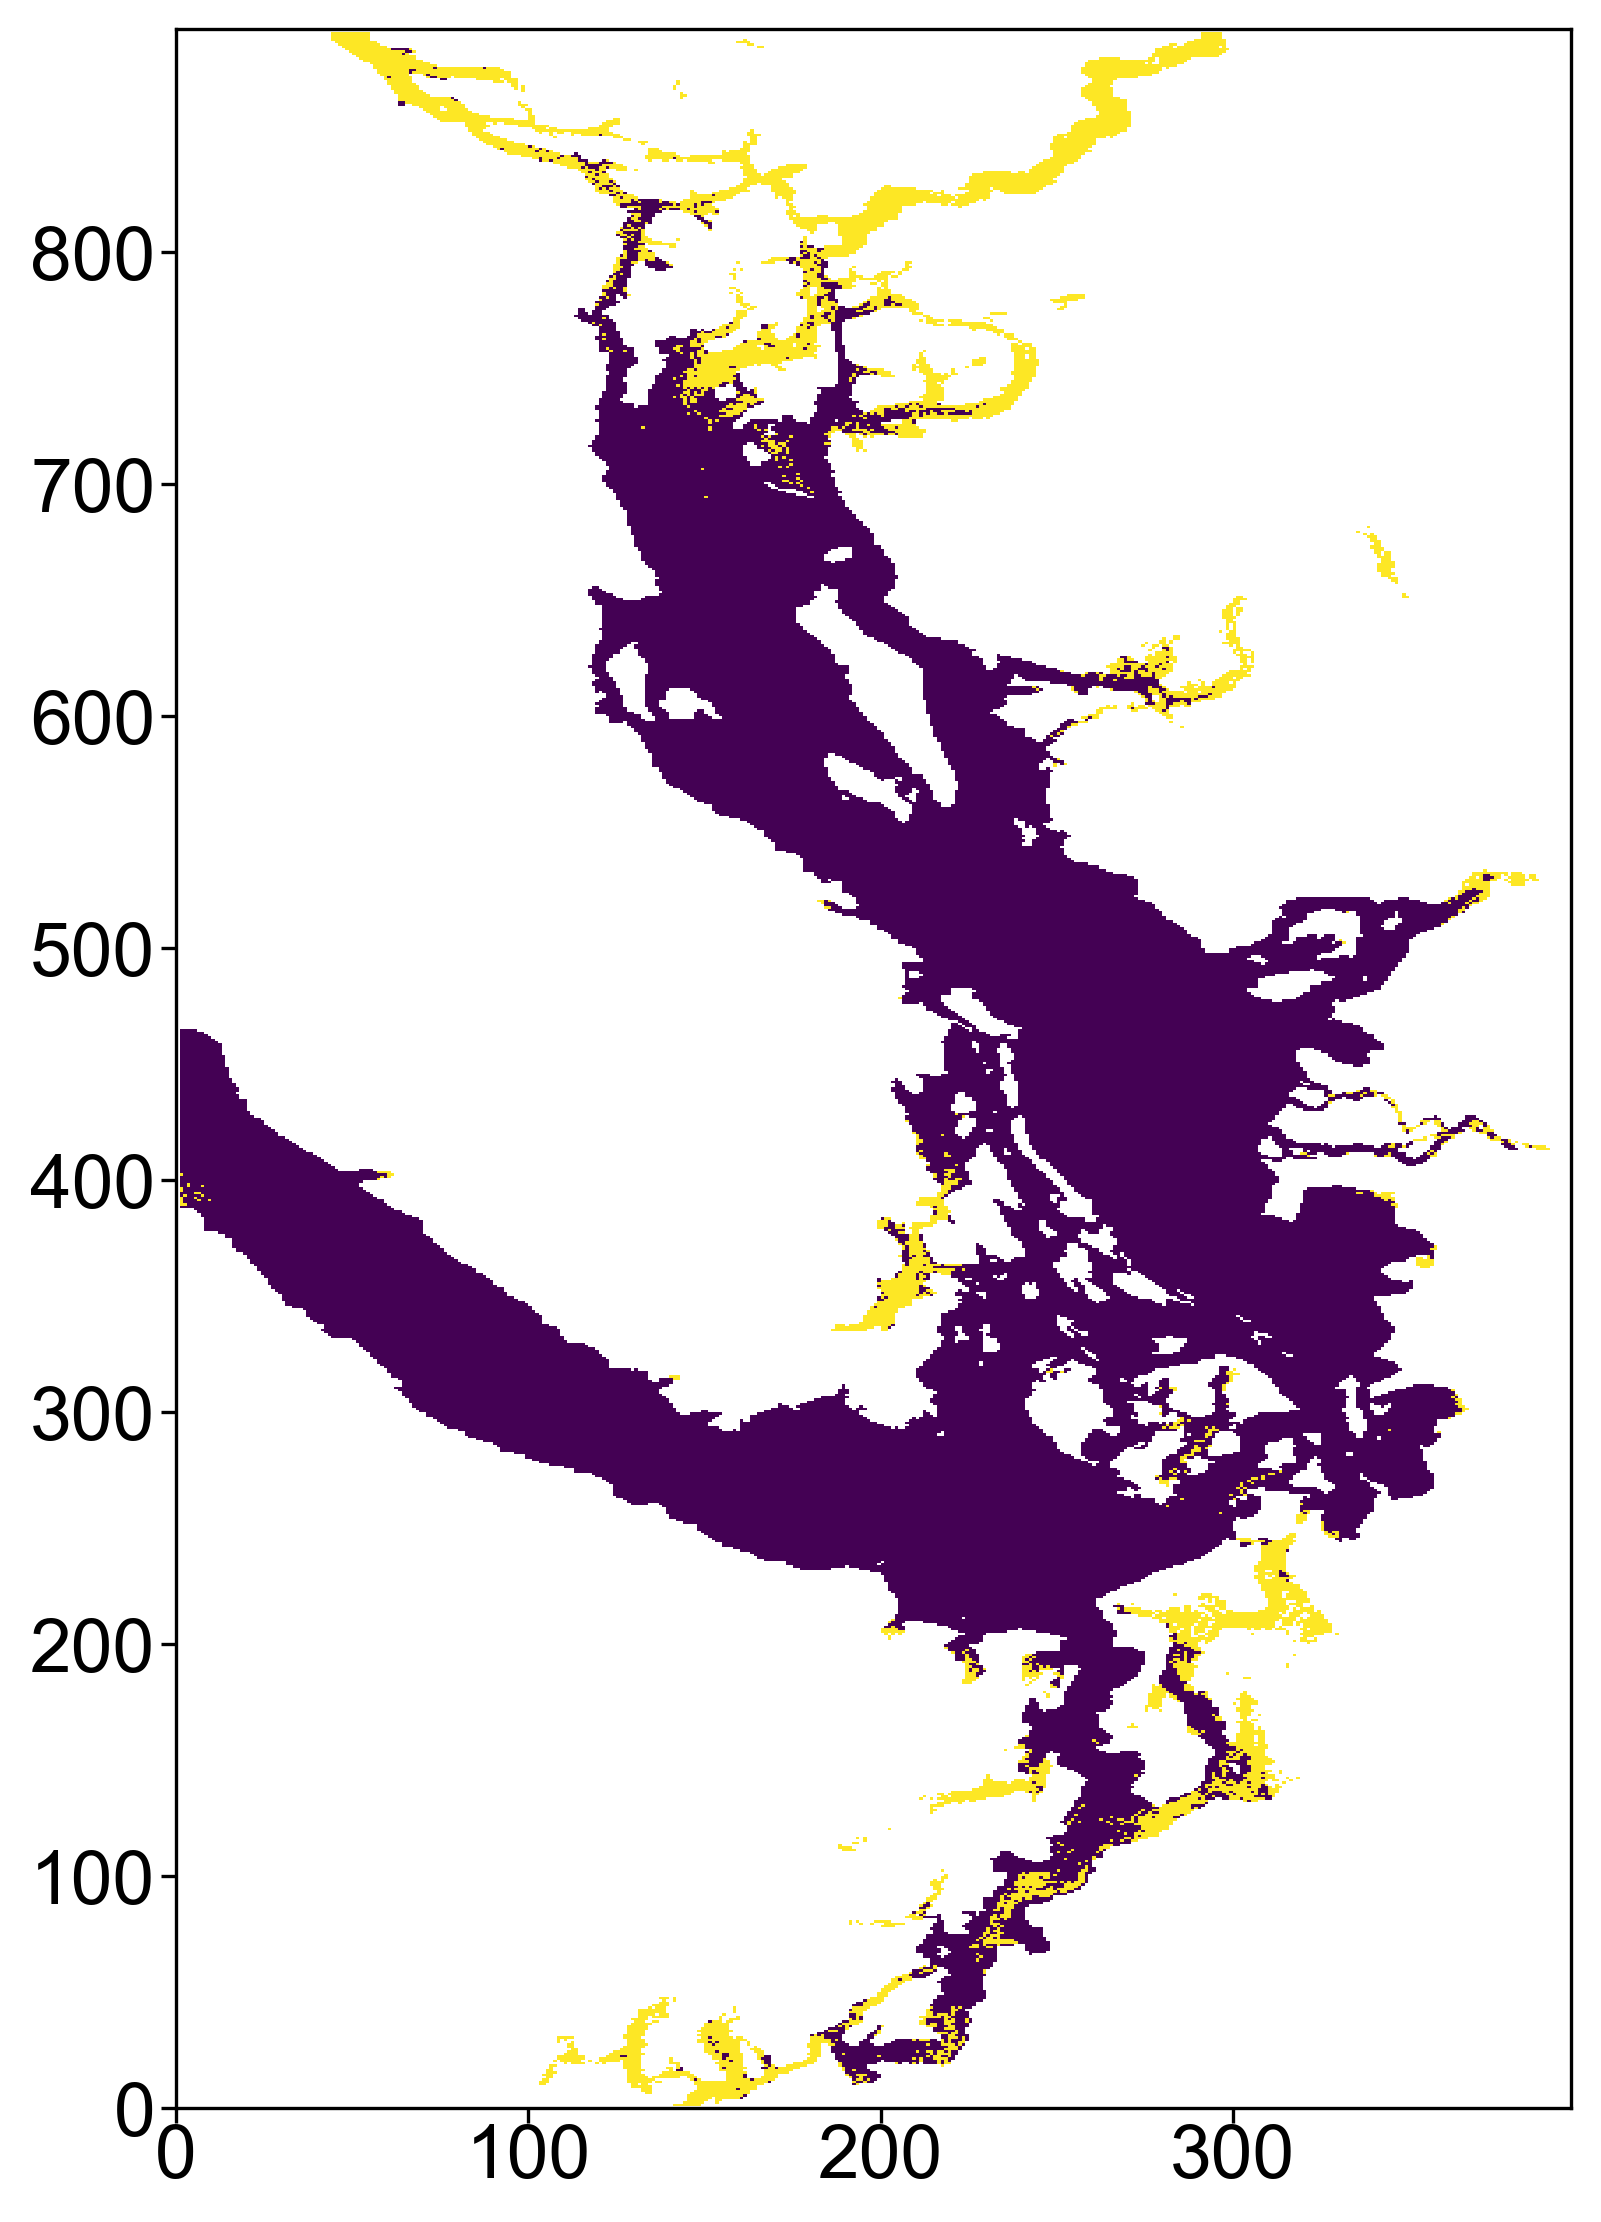

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 9))
C = ax.pcolormesh(depth_range)
cb = fig.colorbar(C, ax=ax);    

fig, ax = plt.subplots(1, 1, figsize=(6, 9))
C = ax.pcolormesh((oil.deeppresence < min_spills) | (
    (location_75 - location_25 > absol) 
    & (location_75 - location_25 > perol*ma_deep_location)) )

In [9]:
depth_range.min()

0.12731586923938476